In [24]:
import sys, os

import numpy as np

import pickle

import torch
import torch.nn.functional as F
from pytorch_msssim import MS_SSIM
from tqdm import tqdm

import model, generator, visuals

# CONFIGvisuals.visualize_dictionary(dictionary)
FOLDER_PATH = "/home/garysnake/Desktop/crsae/pytorch/results/MNIST_feature_tests/2020_06_07_22_53_19/"
MODEL_PATH = FOLDER_PATH+"model_epoch5.pt"
HYP_PATH = FOLDER_PATH+"hyp.pickle"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

result_model = torch.load(MODEL_PATH)
dictionary = result_model.get_param("H").data

print(dictionary.size())


file = open(HYP_PATH, "rb")
hyper_parameter = pickle.load(file)
file.close()

for name, val in hyper_parameter.items():
    print(str(name) + ": " + str(val))



    


torch.Size([64, 1, 7, 7])
experiment_name: MNIST feature tests
dataset: MNIST
network: CRsAE2DUntiedTrainableBias
dictionary_dim: 7
num_conv: 64
stride: 6
L: 5
trainable_bias: True
delta: 50
num_iters: 50
batch_size: 1
num_epochs: 30
normalize: True
lr: 0.0005
lr_decay: 0.7
lr_step: 20
lr_lam: 0.0001
cyclic: False
noiseSTD: 20
shuffle: True
test_path: ../data/test_img/
train_path: ../data/test_img/
device: cuda:0
warm_start: True
info_period: 10
denoising: True
supervised: True
crop_dim: [250, 250]
init_with_DCT: False
init_with_saved_file: False
sigma: 0.18
loss: L1
lam: 0.1
twosided: True
image_set: train
year: 2012
segmentation: True
redo: 1


In [6]:

for i in range(4):
    file = open(FOLDER_PATH+"loss_epoch1.pt", "rb")
    loss = pickle.load(file)
    file.close()
    print(loss)




FileNotFoundError: [Errno 2] No such file or directory: '/home/garysnake/Desktop/crsae/pytorch/results/MNIST_feature_tests/2020_06_07_22_53_19/loss_epoch1.pt'

In [7]:

"""
Data_loader is iterable
[ (image1_tensor, label1_tensor), ...]
"""
# If you want path support different dataset, use below
# data_loader = generator.get_path_loader(1, DATA_PATH, shuffle=False)
data_loader = generator.get_MNIST_loader(1, trainable=False, shuffle=False)
print(len(data_loader))

# Split for visualization
data_nparray = np.array([one_data[0].view(-1).numpy() for one_data in data_loader])
labels_nparray = np.array([one_data[1] for one_data in data_loader])

# Visualize original space
# visuals.visualize_latent_space(model="PCA", data=data_nparray, label=labels_nparray)



10000


In [64]:
 
noisy_img_list = []
embedding_model_np = []
img_model_np = []
num_data = 1
noiseSTD = 40




with torch.no_grad():
    for i, (img_test, _) in enumerate(tqdm(data_loader)):
        noisy_img = (img_test + noiseSTD / 255 * torch.randn(img_test.shape)).to(DEVICE)
        img_new, x_new, _ = result_model(noisy_img)
        noisy_img_list.append(noisy_img.view(-1).to("cpu").detach().numpy())
#         embedding_model_np.append(x_new.view(-1).to("cpu").detach().numpy())
        img_model_np.append(img_new.view(-1).to("cpu").detach().numpy())
        
        # Dictionary atoms
        dictionary_array = torch.split(dictionary, 1,0)

        # Sparse code for each atom
        x_sparse_code = torch.split(x_new, 1, 1)
            
#         embedding_model_np.append(np.array(features).reshape(-1))

        if i == num_data-1:
            break

             
            
# embedding_model_np = np.array(embedding_model_np)
    


  0%|          | 0/10000 [00:00<?, ?it/s]


In [9]:
print(img_model_np[0].size)
print(type(img_model_np[0]))
print(type(embedding_model_np[0]))
print(embedding_model_np[0].size)

784
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
112896


# Show an example of MNIST image + its features

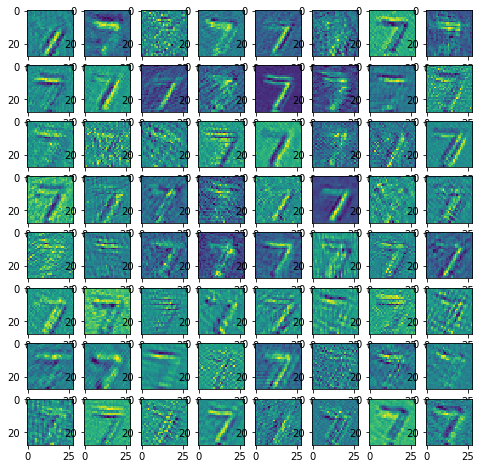

In [75]:
dictionary = result_model.get_param("Wd").data

img_size = img_new.size()

# Crucial - finding the correct size for the sparse code after padding
#  valids_batched is a boolean map that what signal in Hx should stay
_, valids_batched = visuals.split_image(noisy_img, result_model.stride, result_model.dictionary_dim, result_model.device)


'''
    features contains each filter convoluting with its corresponding sparse code 
    
'''
features = []
for x_sparse, atom in zip(x_sparse_code, dictionary_array):
    conv_filter = F.conv_transpose2d(x_sparse, atom, stride=result_model.stride)
    conv_filter = torch.masked_select(conv_filter, valids_batched.bool()
                                     ).reshape(img_size[0], result_model.stride ** 2, *img_size[1:])
    conv_filter = conv_filter.mean(dim = 1,keepdim=False)
    features.append(conv_filter.view(-1).cpu().numpy())

# Print feature
filter_size = int(np.sqrt(features[0].size))
visuals.visualize_img(features, list(range(len(features))), (filter_size, filter_size))


## Comparing the actual output and the stacked features output

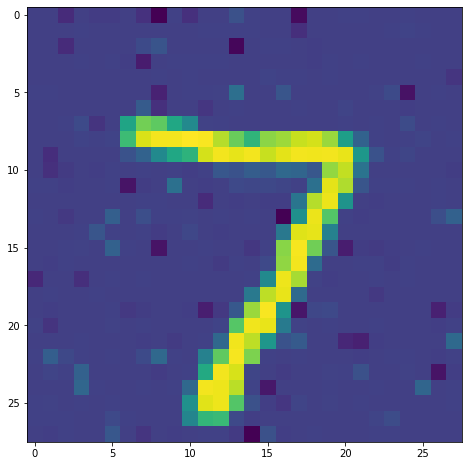

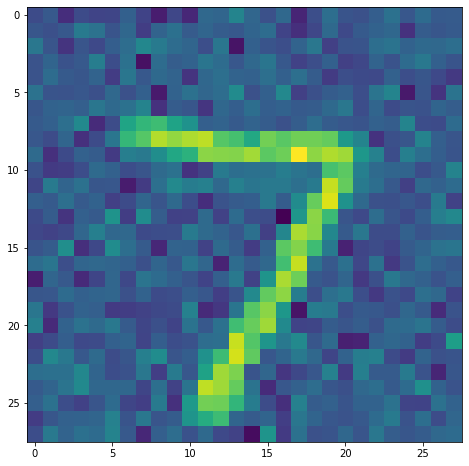

In [77]:
# Visualize the original image
img_size = img_new.size()[2]
visuals.visualize_img([img_new.view(-1).cpu().detach().numpy()], [0], (img_size,img_size))

# Visualize the reconstructed image
combine = np.array(features)
combine_pics = np.mean(combine, axis=0)
visuals.visualize_img([combine_pics], [1], (filter_size, filter_size))


## Visualizing the high dimension sparse code with TSNE and PCA

/home/garysnake/.local/lib/python3.6/site-packages/seaborn/axisgrid.py:243: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


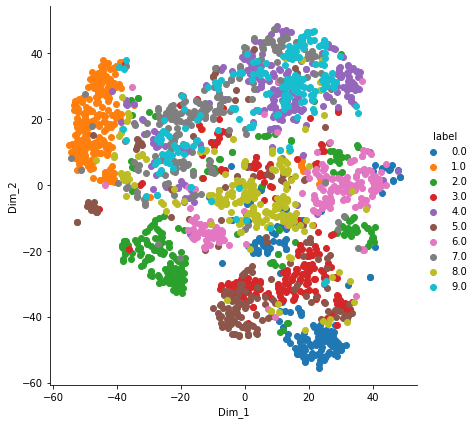

In [59]:
# Visualize the Latent_space 
# visuals.visualize_img(img_model_np[:20], labels_nparray[:20], (28,28))
# visuals.visualize_latent_space("TSNE", noisy_img_list[:num_data], labels_nparray[:num_data])
visuals.visualize_latent_space("TSNE", embedding_model_np, labels_nparray[:num_data])
# visuals.visualize_latent_space("PCA", embedding_model_np, labels_nparray[:num_data])



## Visualizing the deblurring reconstruction

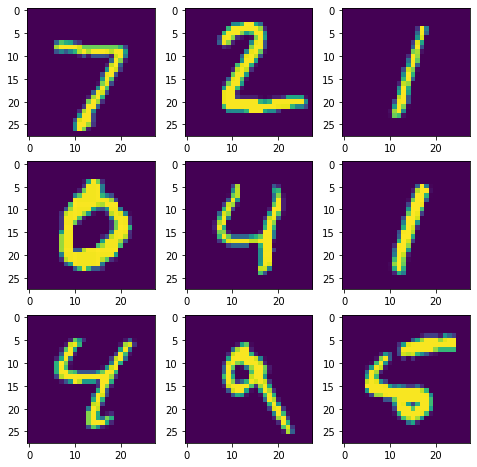

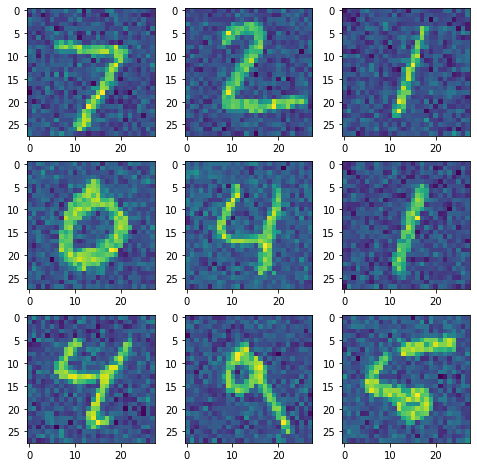

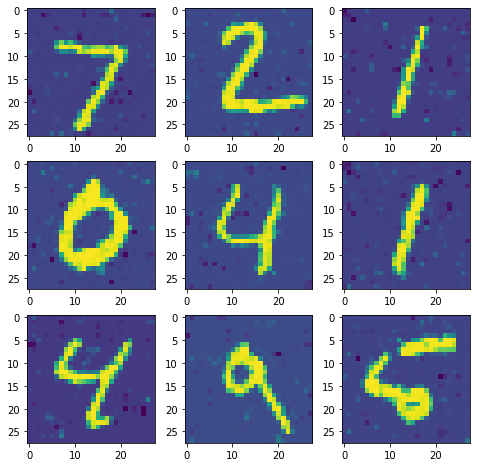

In [51]:
# Visualize the image itself to see the noisy input
visuals.visualize_img(data_nparray[:9], labels_nparray[:9], (28,28))
visuals.visualize_img(noisy_img_list[:9], labels_nparray[:9], (28,28))
visuals.visualize_img(img_model_np[:9], labels_nparray[:9], (28,28))


## Visualizing the dictionary

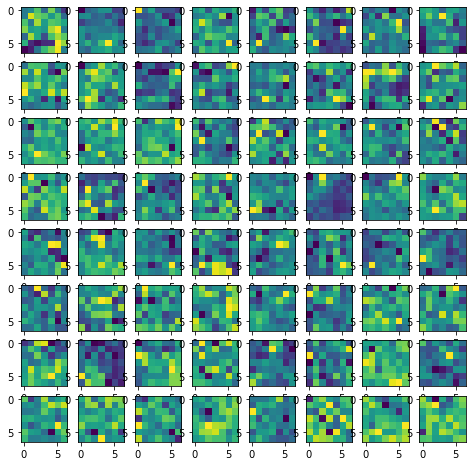

In [42]:
visuals.visualize_dictionary(dictionary.squeeze(1).cpu())


## Load PSNR 

In [40]:
# PSNR = np.load(FOLDER_PATH + "psnr_epoch0.npy")
# print(np.mean(PSNR))
# PSNR = np.load(FOLDER_PATH + "psnr_epoch1.npy")

PSNR = np.load(FOLDER_PATH + "psnr_init.npy")
print(np.mean(PSNR))
for i in range(1):
    PSNR = np.load(FOLDER_PATH + "psnr_epoch{}.npy".format(i))
    print(np.mean(PSNR))  

-109.85774949441758
31.33772150196228
